In [1]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache, BrainObservatoryNwbDataSet
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import hog
from skimage import data, exposure
from scipy.stats import zscore
import pandas as pd 
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [2]:
filter_json = """
[
    {
        "field": "area",
        "op": "in",
        "value": [
            "VISp"
        ]
    },
    {
        "field": "tld1_name",
        "op": "in",
        "value": [
            "Slc17a7-IRES2-Cre"
        ]
    }
]
"""
       
filters = json.loads(filter_json)
boc = BrainObservatoryCache(manifest_file="brain_observatory/manifest.json")
cells = boc.get_cell_specimens(filters=filters)
cells_df = pd.DataFrame(cells)
cells_df.columns.unique().tolist()
cont_ids = cells_df['experiment_container_id'].unique()
experiments = boc.get_ophys_experiments(experiment_container_ids=cont_ids, include_failed=False, require_eye_tracking=True)
exp_ids = [d['id'] for d in experiments]
exp_ids = exp_ids[:20]

In [3]:

boc.get_ophys_experiment_stimuli(exp_ids[2])
exp2 = boc.get_ophys_experiment_data(exp_ids[2])
exp2.get_stimulus_epoch_table()

,stimulus,start,end
0,static_gratings,742,15189
1,natural_scenes,16093,30540
2,spontaneous,30690,39568
3,natural_scenes,39569,54016
4,static_gratings,54919,69366
5,natural_movie_one,70269,79298
6,natural_scenes,80201,96077
7,static_gratings,97357,113608


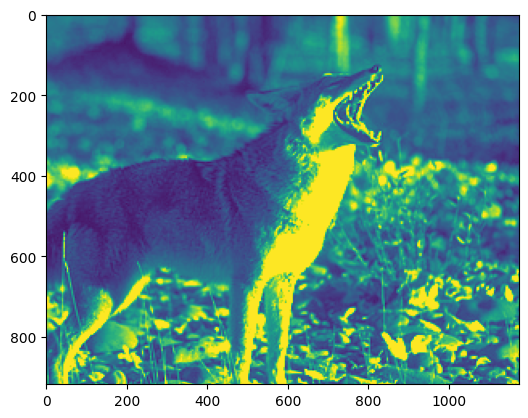

In [4]:
ims = exp2.get_stimulus_template('natural_scenes')
plt.imshow(ims[14,:,:])

In [111]:
a.mean_sweep_response

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,dx
0,0.032509,8.015866,7.436517,10.813445,1.264137,5.861928,3.995627,7.245328,3.989591,1.438071,-0.086036,2.162383,10.136319,4.792071,5.871452,15.085291,19.006176,3.579606,14.196437,0.877752,2.062589,6.000815,0.198358,2.355563,10.848976,11.844145,3.489437,3.353822,2.925830,6.402688,5.245743,5.809738,3.700626,1.671126,5.175149,15.812558,3.263268,0.386861,7.919723,5.842477,...,4.964649,2.683703,1.562285,8.654401,3.694395,4.024769,3.975068,4.396956,1.865435,3.998146,0.249463,3.688094,12.069968,3.548295,0.128502,1.630800,3.699517,5.019357,6.664700,6.627887,3.549196,1.354403,9.143191,2.241983,27.425550,6.247869,5.116199,10.403590,0.959727,3.896507,0.045925,4.191077,5.830772,3.176071,4.516113,12.035085,1.340996,6.940707,5.573480,11.617166
1,8.189063,10.525483,8.586065,17.019859,4.152932,1.118904,3.311929,8.485019,3.346359,1.883670,0.932752,7.160777,9.701128,6.112388,10.925781,20.789104,20.061541,9.479701,15.855407,7.525744,-1.063722,8.970002,3.053089,4.797511,7.870510,10.098916,6.303842,4.371340,9.525652,8.130078,4.208236,5.704627,8.018240,1.070304,6.442552,14.850573,4.453703,-0.786917,20.713060,12.900064,...,6.290050,7.234999,4.035535,12.043790,3.238197,10.198346,4.677932,8.493104,6.816189,1.601793,1.749382,7.375289,28.355343,18.321598,2.802136,3.478950,4.050985,5.717011,11.643385,0.292936,7.138572,0.959425,4.359774,14.215995,37.760155,8.227759,3.939859,12.120277,5.870561,7.835464,5.948662,5.680378,11.199626,5.248062,7.636565,20.079535,3.783461,6.397416,5.799248,10.460691
2,10.188958,11.398816,6.087817,9.376039,6.150573,-3.071237,1.301695,1.732581,0.678465,0.039947,2.363375,3.663235,3.976622,1.583716,12.775055,7.660432,-1.990934,10.199432,-1.176418,16.385006,-0.333251,3.612134,0.372239,1.666568,8.020783,8.265843,8.840529,-0.746128,11.021574,3.674148,2.876333,4.418985,4.448783,-0.673397,0.409770,2.739614,3.545753,-4.344130,9.795786,6.861927,...,5.532748,3.977850,2.546454,2.628388,6.136508,6.876603,4.565581,1.767592,5.075480,-0.284223,31.235197,4.710446,-0.057595,21.093929,2.595881,1.647586,4.778926,7.379161,6.146778,-1.942286,9.086989,8.079400,-3.456864,41.918434,-1.887498,0.111723,1.691536,0.211295,2.161697,3.682279,11.120880,4.585182,8.535882,1.033698,1.115950,-1.076236,38.559048,3.510346,1.299125,9.804935
3,6.014566,11.518267,2.710705,-3.849635,-0.651291,-0.463268,0.508402,-4.489005,0.612158,1.883126,3.416064,31.984436,0.787761,3.086993,3.179041,5.178473,-7.695076,4.004583,-2.678182,20.613955,1.010339,1.906935,-1.548990,1.525802,8.665045,-6.965418,1.074793,-3.497034,4.267908,2.903139,-0.627149,2.751087,-0.030652,-3.070975,-2.575146,-3.098687,0.221090,-8.106912,-2.300734,-2.564938,...,0.537175,0.162950,-2.524408,-6.158913,2.245685,3.062147,-2.080289,-0.864487,1.760447,-2.373717,39.227348,-1.946418,-9.604230,3.907879,3.140072,1.143800,3.764078,4.492618,15.108468,-3.502563,9.938936,4.847407,-6.432849,35.896355,-12.832506,-2.248713,0.883143,-3.189222,-2.974186,-2.003071,14.168024,5.997997,2.800412,-2.942229,-4.085678,-4.951329,91.748238,-1.385800,-3.980108,9.667398
4,-2.801713,1.066885,-4.998443,-8.983289,-1.723590,1.308610,-3.518429,-4.745209,0.356021,5.657435,0.060021,75.278374,-0.421966,-2.085391,-5.071789,-1.201760,0.047220,-4.177865,-6.545372,2.635878,1.896474,1.923890,-2.736936,4.885330,-0.614838,-17.889471,-3.681283,-4.475203,1.619465,-6.245087,-7.182533,-6.207317,-1.336962,-7.781679,-1.810959,-2.781172,-5.587949,-12.949397,-3.412764,-2.191428,...,-2.943319,0.156495,-4.914690,-0.908922,-2.273862,-5.483781,-5.004847,-3.866439,-0.195914,-0.728383,-8.727946,-7.955093,-20.918278,-6.209521,-3.287382,1.003101,5.374904,0.420634,15.088346,5.927977,-0.775141,-2.455870,-8.940310,13.400432,-19.763708,-4.785747,-1.095438,-7.399173,-8.822832,-7.758317,-2.585366,5.314728,-7.

In [112]:
5950 /118

50.42372881355932

In [53]:
a = boc.get_ophys_experiment_analysis(exp_ids[2], 'natural_scenes')

In [89]:
a.number_scenes

119

In [60]:
resp = a.get_response()

In [44]:
#get_response() docstring

#  ''' Computes the mean response for each cell to each stimulus
# condition.  Return is
# a (# scenes, # cells, 3) np.ndarray.  The final dimension
# contains the mean response to the condition (index 0), standard
# error of the mean of the response
# to the condition (index 1), and the number of trials with a
# significant (p < 0.05) response
# to that condition (index 2).'''

resp.shape


(119, 229, 3)

In [45]:
exp2.get_stimulus_template('natural_scenes').shape

(118, 918, 1174)

In [91]:
0 in exp2.get_stimulus_table('natural_scenes')['frame']
# exp2.get_stimulus_table('static_gratings')

True

228

In [54]:
exp2.get_stimulus(113586)

((113586,
  113592.99,
  {'end': 113593,
   'frame': nan,
   'orientation': 120.0,
   'phase': 0.25,
   'repeat': nan,
   'spatial_frequency': 0.03999999910593033,
   'start': 113586,
   'stimulus': 'static_gratings'}),
 None)

In [70]:
# plt.imshow(a.get_representational_similarity()[0,:,:])
repsim = a.get_representational_similarity()

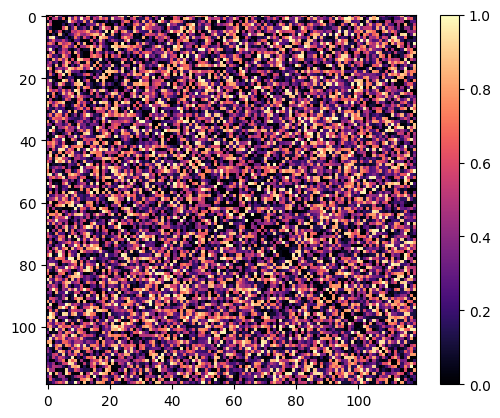

In [82]:
plt.imshow(repsim[1], cmap = 'magma')
plt.colorbar()

In [120]:
for i in range(4):
    print(i)

0
1
2
3


c:\Users\valen\anaconda3\envs\allen_brain_observatory\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\valen\anaconda3\envs\allen_brain_observatory\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


<AxesSubplot:xlabel='tsne1', ylabel='tsne2'>

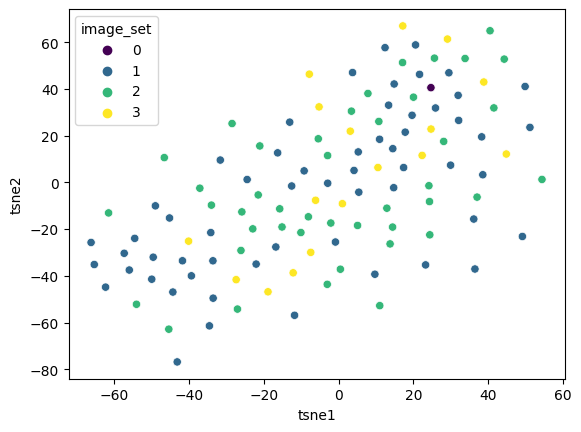

In [190]:
tsne = TSNE(n_components=2, random_state=42)

X = zscore(resp[:,:,0], axis = 0)
emb =tsne.fit_transform(X)
imset = np.array([0]+[1]*58 +[2]*(101-58)+[3]*(118-101)).T
emb_df = pd.DataFrame({'tsne1':emb[:,0],'tsne2':emb[:,1],'image_set':imset})
sns.scatterplot(x = 'tsne1', y = 'tsne2', hue='image_set',data = emb_df, palette='viridis')

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

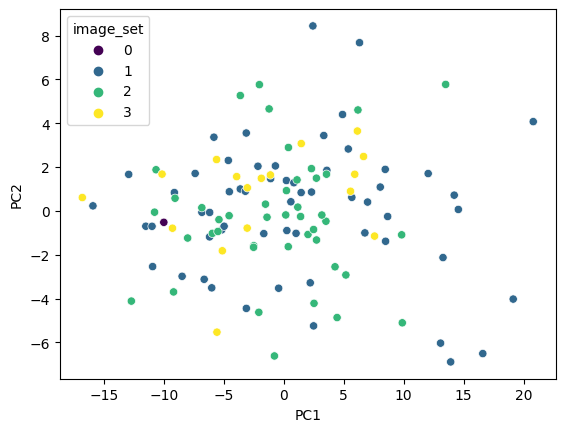

In [193]:
resp_tot = a.mean_sweep_response

pca = PCA(n_components=2)
# X = zscore(resp_tot.values, axis = 0)
emb = pca.fit_transform(X)

emb_df = pd.DataFrame({'PC1':emb[:,0], 'PC2':emb[:,1], 'image_set':imset})
sns.scatterplot(x = 'PC1', y = 'PC2', hue='image_set',data = emb_df, palette='viridis')

In [54]:
stim_table = a.stim_table
stim_table['image_set'] = np.nan
stim_table.loc[stim_table['frame']<0, 'image_set'] = 0
stim_table.loc[(stim_table['frame']<=57)&(stim_table['frame']>=0), 'image_set'] = 1
stim_table.loc[(stim_table['frame']<=100)&(stim_table['frame']>=58), 'image_set'] = 2
stim_table.loc[(stim_table['frame']<=118)&(stim_table['frame']>=101), 'image_set'] = 3


c:\Users\valen\anaconda3\envs\allen_brain_observatory\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\valen\anaconda3\envs\allen_brain_observatory\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


<AxesSubplot:xlabel='tsne1', ylabel='tsne2'>

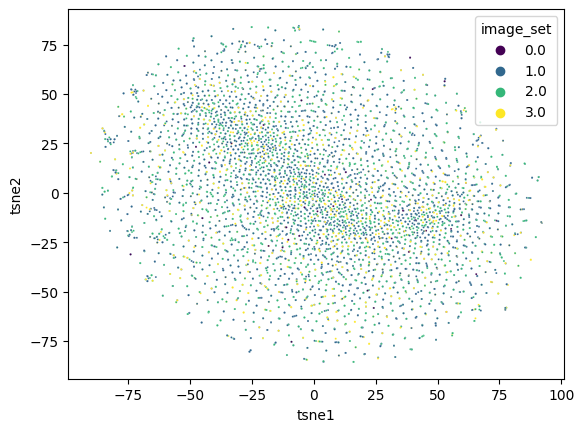

In [195]:
resp_tot = a.mean_sweep_response

tsne = TSNE(n_components=2)
X = zscore(resp_tot.values, axis = 0)
emb2 = tsne.fit_transform(X)

emb2_df = pd.DataFrame({'tsne1':emb2[:,0], 'tsne2':emb2[:,1], 'image_set':stim_table['image_set'].values})
sns.scatterplot(x = 'tsne1', y = 'tsne2', hue='image_set',data = emb2_df, s = 2, palette='viridis')

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

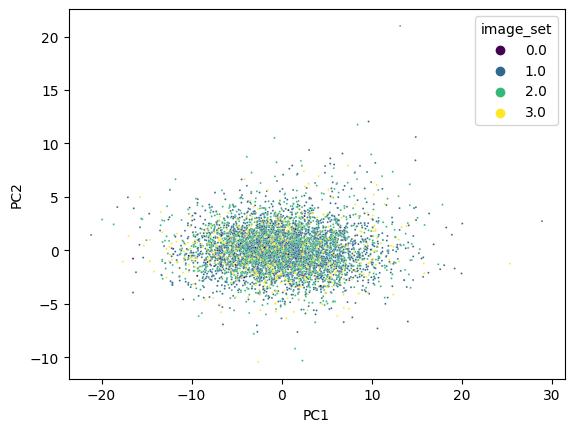

In [196]:
resp_tot = a.mean_sweep_response

pca = PCA(n_components=2)
X = zscore(resp_tot.values, axis = 0)
emb2 = pca.fit_transform(X)

emb2_df = pd.DataFrame({'PC1':emb2[:,0], 'PC2':emb2[:,1], 'image_set':stim_table['image_set'].values})
sns.scatterplot(x = 'PC1', y = 'PC2', hue='image_set',data = emb2_df, s = 2, palette='viridis')

In [5]:
features =[]
for i in range(ims.shape[0]):
    image = ims[i,:,:]

    fd = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1,1), visualize=False)
    features.append(fd)

# plt.imshow(image)
# plt.figure()
# plt.imshow(hog_image)

In [6]:
figures = pd.DataFrame(features)

In [10]:
r = np.corrcoef(figures.values)

<AxesSubplot:>

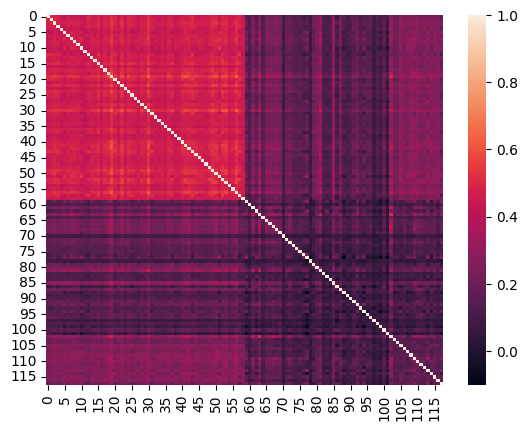

In [29]:
from matplotlib.pyplot import imshow


# sns.clustermap(figures.T, row_cluster=False, metric='correlation')
sns.heatmap(r)

In [72]:
from sklearn.metrics.pairwise import pairwise_distances

dist = pairwise_distances(figures, metric='correlation')

In [111]:
from sklearn.cluster import AgglomerativeClustering

cl = AgglomerativeClustering(distance_threshold = 0, n_clusters = None, affinity='precomputed', linkage='single')
cl.fit(dist)

AgglomerativeClustering(affinity='precomputed', distance_threshold=0,
                        linkage='single', n_clusters=None)

In [112]:
from scipy.cluster.hierarchy import dendrogram


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

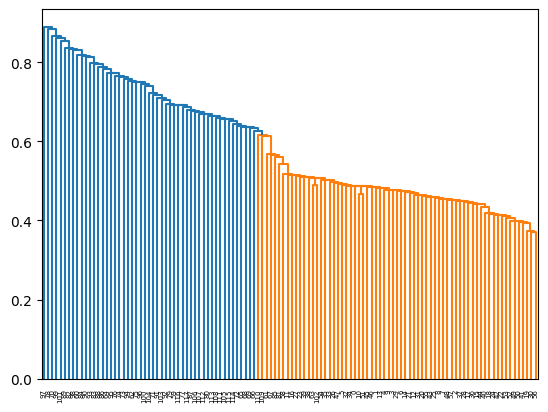

In [114]:
plot_dendrogram(cl)
# plt.xlabel("Number of points in node (or index of point if no parenthesis).")
# plt.imshow(dist)
plt.show()

(array([12., 12., 12., 11., 12., 12., 11., 12., 12., 12.]),
 array([  0. ,  11.7,  23.4,  35.1,  46.8,  58.5,  70.2,  81.9,  93.6,
        105.3, 117. ]),
 <BarContainer object of 10 artists>)

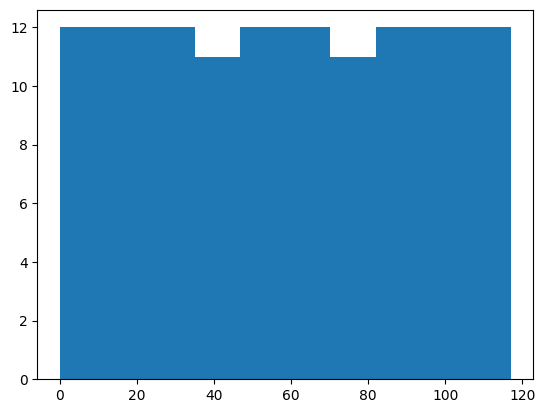

In [116]:

labels = cl.fit_predict(dist)
plt.hist(labels)

(0, 75)
(1, 79)
(2, 99)
(3, 83)
(4, 81)
(5, 71)
(6, 85)
(7, 96)
(8, 95)
(9, 82)
(10, 88)
(11, 59)
(12, 89)
(13, 80)
(14, 86)
(15, 104)
(16, 60)
(17, 102)
(18, 107)
(19, 116)
(20, 91)
(21, 87)
(22, 110)
(23, 62)
(24, 108)
(25, 94)
(26, 69)
(27, 61)
(28, 101)
(29, 84)
(30, 117)
(31, 90)
(32, 73)
(33, 68)
(34, 74)
(35, 67)
(36, 103)
(37, 100)
(38, 64)
(39, 63)
(40, 106)
(41, 115)
(42, 109)
(43, 93)
(44, 105)
(45, 77)
(46, 78)
(47, 70)
(48, 97)
(49, 113)
(50, 114)
(51, 76)
(52, 112)
(53, 111)
(54, 66)
(55, 92)
(56, 38)
(57, 98)
(58, 58)
(59, 65)
(60, 39)
(61, 54)
(62, 45)
(63, 72)
(64, 33)
(65, 48)
(66, 51)
(67, 55)
(68, 49)
(69, 50)
(70, 31)
(71, 56)
(72, 47)
(73, 41)
(74, 40)
(75, 23)
(76, 37)
(77, 34)
(78, 24)
(79, 32)
(80, 19)
(81, 57)
(82, 35)
(83, 28)
(84, 43)
(85, 27)
(86, 16)
(87, 36)
(88, 29)
(89, 13)
(90, 52)
(91, 30)
(92, 14)
(93, 11)
(94, 44)
(95, 17)
(96, 53)
(97, 42)
(98, 15)
(99, 18)
(100, 25)
(101, 26)
(102, 7)
(103, 6)
(104, 12)
(105, 21)
(106, 8)
(107, 3)
(108, 20)
(109, 

(array([12., 12., 12., 11., 12., 12., 11., 12., 12., 12.]),
 array([  0. ,  11.7,  23.4,  35.1,  46.8,  58.5,  70.2,  81.9,  93.6,
        105.3, 117. ]),
 <BarContainer object of 10 artists>)

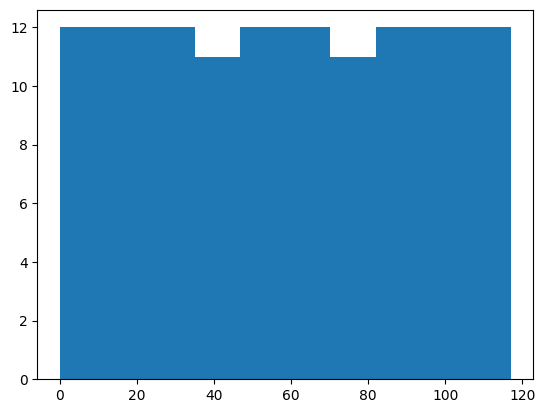

In [117]:
np.arange(-1,118)
stim_table['frame'][0]
[print(ar) for ar in zip(np.arange(0,118), labels)]
plt.hist(labels)

In [119]:
image_map.keys()

dict_keys([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116])

In [121]:
image_map = {a:b for a, b in zip(np.arange(0,118), labels)}
image_map[-1] = 0
imclust = [image_map[im] for im in stim_table['frame'].values]

c:\Users\valen\anaconda3\envs\allen_brain_observatory\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\valen\anaconda3\envs\allen_brain_observatory\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


<AxesSubplot:xlabel='tsne1', ylabel='tsne2'>

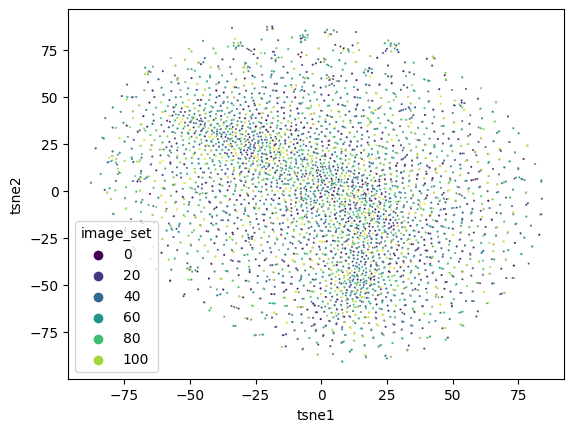

In [123]:
resp_tot = a.mean_sweep_response

tsne = TSNE(n_components=2)
X = zscore(resp_tot.values, axis = 0)
emb2 = tsne.fit_transform(X)

emb2_df = pd.DataFrame({'tsne1':emb2[:,0], 'tsne2':emb2[:,1], 'image_set':imclust})
sns.scatterplot(x = 'tsne1', y = 'tsne2', hue='image_set',data = emb2_df, s = 2, palette='viridis')

<AxesSubplot:xlabel='tsne1', ylabel='tsne2'>

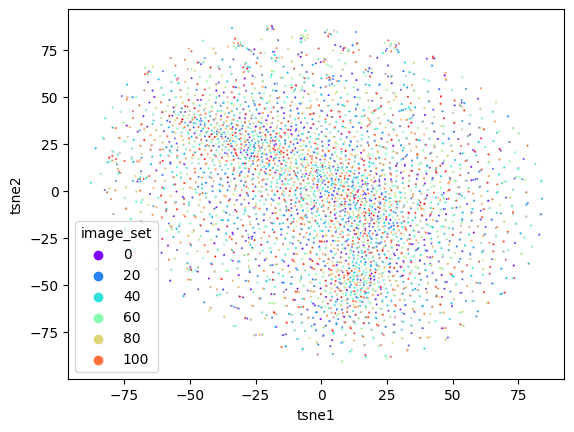

In [125]:
sns.scatterplot(x = 'tsne1', y = 'tsne2', hue='image_set',data = emb2_df, s = 2, palette='rainbow')

In [66]:
resp.shape
labels.shape

(33288,)

In [62]:
tsne = TSNE(n_components=2, random_state=42)

X = zscore(resp[:,:,0], axis = 0)
emb =tsne.fit_transform(X)
# imset = np.array([0]+[1]*58 +[2]*(101-58)+[3]*(118-101)).T
emb_df = pd.DataFrame({'tsne1':emb[:,0],'tsne2':emb[:,1],'image_set':labels})
sns.scatterplot(x = 'tsne1', y = 'tsne2', hue='image_set',data = emb_df, palette='viridis')

c:\Users\valen\anaconda3\envs\allen_brain_observatory\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\valen\anaconda3\envs\allen_brain_observatory\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


ValueError: arrays must all be same length